### Objective:
- The objective from this task is to use your NLP skills to build a ML model can <b>classify the news categories</b>.


### Fixed Rules:
- train test split 80% : 20%
- all random seeds = 42

## Load Libraries

In [62]:
import pandas as pd 
import numpy as np

## Load Dataset

In [63]:
df = pd.read_json('Dataset.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [65]:
concatedDf = df[['category','headline','short_description']].copy()
concatedDf['full_news'] = df.headline+', '+ df.short_description
concatedDf.head()

,category,headline,short_description,full_news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...


In [66]:
concatedDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   category           200853 non-null  object
 1   headline           200853 non-null  object
 2   short_description  200853 non-null  object
 3   full_news          200853 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


## EDA

- Check NaNs

In [67]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=concatedDf.columns, y=np.sum(concatedDf.isna().values, axis=0))])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title_text='Missing values')
fig.show()

- Check Duplicates

In [68]:
concatedDf.duplicated().sum()

470

- Check Dataset Balancing

In [69]:
values = concatedDf.category.value_counts()
labels = concatedDf.category.value_counts().index

In [70]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2,specs=[[{"type": "domain"}, {"type": "xy"}]])

fig.add_trace(
    go.Pie(labels=labels, values=values),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=labels, y=values),
    row=1, col=2
)



fig.update_layout(title_text="Target Distribution in Dataset" ,showlegend=False)
fig.show()

- show samples of data texts to find out required preprocessing steps

In [71]:
for i in labels:
    tempDf = concatedDf[concatedDf.category == i]   
    
    print('\n***** {} ***** \n'.format(i))
    print(tempDf.full_news.iloc[0])


***** POLITICS ***** 

Trump's Crackdown On Immigrant Parents Puts More Kids In An Already Strained System, Last month a Health and Human Services official revealed the government was unable to locate nearly 1,500 children who had been released from its custody.

***** WELLNESS ***** 

Why Overeating Doesn't Make You Fat, If you take the right approach to ending your food addiction, your cravings will go away in just a day or so. The right approach

***** ENTERTAINMENT ***** 

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song, Of course it has a song.

***** TRAVEL ***** 

14 Ways To Make Family Road Trips Easier, From Parents Who've Been There, Having waterproof covers on the seats is kind of brilliant.

***** STYLE & BEAUTY ***** 

Things You Need To Know Before You Get A Tattoo You'll Regret, What's the number one thing you need to know according to our expert? Be prepared.

***** PARENTING ***** 

A Baby Book of Disasters, Having a child is nothing if not

## Cleaning & Preprocessing

- 1 Remove duplicates
- 2 Remove numbers from all news
- 3 Remove unchars word
- 4 Check for websites ( http...)
- 5 Normalizing

- Remove duplicates

In [72]:
dfModified = concatedDf.copy()

dfModified.drop_duplicates(inplace = True)

In [73]:
dfModified.duplicated().sum(), concatedDf.duplicated().sum()

(0, 470)

- Remove numbers from all comments

In [74]:
import re


dfModified['full_news']=dfModified['full_news'].apply(lambda x: re.sub('\d+','', x))
dfModified.full_news[0], concatedDf.full_news[0]

('There Were  Mass Shootings In Texas Last Week, But Only  On TV, She left her husband. He killed their children. Just another day in America.',
 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV, She left her husband. He killed their children. Just another day in America.')

- Remove unchars word

In [75]:
dfModified['full_news'] = dfModified['full_news'].apply(lambda x: re.sub('[^A-Za-z]',' ',x))
dfModified.full_news[5], concatedDf.full_news[5]

('Morgan Freeman  Devastated  That Sexual Harassment Claims Could Undermine Legacy   It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor   he said in a statement ',
 'Morgan Freeman \'Devastated\' That Sexual Harassment Claims Could Undermine Legacy, "It is not right to equate horrific incidents of sexual assault with misplaced compliments or humor," he said in a statement.')

- Check for websites ( http...)

In [76]:
concatedDf.full_news.apply(lambda x: re.findall('https?://\S+|www\.\S+',x))

0         []
1         []
2         []
3         []
4         []
          ..
200848    []
200849    []
200850    []
200851    []
200852    []
Name: full_news, Length: 200853, dtype: object

## Normalizing

- Lower all words

In [77]:
dfModified['full_news']=dfModified['full_news'].apply(lambda x: x.lower())
dfModified.full_news[7], concatedDf.full_news[7]

('what to watch on amazon prime that s new this week  there s a great mini series joining this week ',
 "What To Watch On Amazon Prime That’s New This Week, There's a great mini-series joining this week.")

- Remove stopwords

In [78]:
import nltk 
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

dfModified['full_news']=dfModified['full_news'].\
                                apply(lambda x : [word for word in x.split()  if word not in stop_words])

dfModified.full_news[4], concatedDf.full_news[4]

(['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'pick',
  'dog',
  'dietland',
  'actress',
  'said',
  'using',
  'bags',
  'really',
  'cathartic',
  'therapeutic',
  'moment'],
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog, The "Dietland" actress said using the bags is a "really cathartic, therapeutic moment."')

- Lemmatization

In [79]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

dfModified['full_news']=dfModified['full_news'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

dfModified.full_news[233], concatedDf.full_news[233]

(['gop',
  'lawmaker',
  'soon',
  'allowed',
  'review',
  'classified',
  'info',
  'russia',
  'investigation',
  'trump',
  'want',
  'know',
  'whether',
  'fbi',
  'informant',
  'infiltrated',
  'campaign',
  'political',
  'purpose'],
 'GOP Lawmakers Will Soon Be Allowed To Review Classified Info On Russia Investigation, Trump wants to know whether an FBI informant infiltrated his campaign for political purposes.')

- Change each row of the comments from list into a single string

In [80]:
dfModified['full_news']=dfModified['full_news'].apply(lambda x: ' '.join(x))

dfModified.full_news[233], concatedDf.full_news[233]

('gop lawmaker soon allowed review classified info russia investigation trump want know whether fbi informant infiltrated campaign political purpose',
 'GOP Lawmakers Will Soon Be Allowed To Review Classified Info On Russia Investigation, Trump wants to know whether an FBI informant infiltrated his campaign for political purposes.')

- Preprocessing Pipline Function

In [81]:
def preprocessPipline(data, labelName):
    
    dataTemp = data.copy()
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('\d+','', x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: re.sub('[^A-Za-z]',' ',x))
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: x.lower())
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x : [word for word in x.split()  if word not in stop_words])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    dataTemp[labelName] = dataTemp[labelName].apply(lambda x: ' '.join(x))
    return dataTemp

## Modelling

In [82]:
commentLength = {}

for i in dfModified.full_news.apply(lambda x:x.split()):
    if '{}'.format(len(i)) in commentLength.keys():
        
        commentLength['{}'.format(len(i))] += 1
    else:
        commentLength['{}'.format(len(i))] = 1


In [83]:
commentLengthDf = pd.DataFrame.from_dict(commentLength, orient='index').reset_index()
commentLengthDf = commentLengthDf.rename(columns={'index': 'newsLen', 0: 'freq'})
commentLengthDf['newsLen'] = pd.to_numeric(commentLengthDf['newsLen'])

commentLengthDf.head()

,newsLen,freq
0,13,9123
1,11,7274
2,15,11273
3,19,11990
4,18,12675


In [84]:
import plotly.express as px
fig = px.bar(commentLengthDf.sort_values('newsLen'), x='newsLen', y='freq')
fig.show()

In [85]:
# assume the maxnewLen = 30
maxnewLen = 37

In [86]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token="unk")
tokenizer.fit_on_texts(dfModified.full_news)
tokenizer_seq = tokenizer.texts_to_sequences(dfModified.full_news)


In [87]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_padded = pad_sequences(tokenizer_seq, maxlen=maxnewLen, padding='post',truncating='post')
tokenizer_padded[2]

array([5143, 3209, 6912,   22,    7,  268,  601, 4715, 1810, 2328,    1,
       2258, 2919,  975, 1693,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [88]:
vocab_size = len(tokenizer.word_index)
vocab_size

75489

In [89]:
Y_data = dfModified['category']

from sklearn.model_selection import train_test_split
x_train, x_val ,y_train ,y_val = train_test_split(tokenizer_padded, Y_data, test_size=0.2, stratify=Y_data)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((160306, 37), (40077, 37), (160306,), (40077,))

In [90]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [91]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

y_train.shape, y_val.shape

((160306, 41), (40077, 41))

- LSTM

In [97]:
import tensorflow as tf
from keras import layers,models

model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(vocab_size+1, 128))
model_lstm.add(layers.LSTM(64))
model_lstm.add(layers.Dense(len(labels), activation='softmax'))


In [98]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [99]:
import keras 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses


model_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', f1_m])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         9662720   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 41)                2665      
Total params: 9,714,793
Trainable params: 9,714,793
Non-trainable params: 0
_________________________________________________________________


In [100]:
x_trainArr = np.asarray(x_train)
x_valArr = np.asarray(x_val)

In [101]:
history = model_lstm.fit(x_trainArr,y_train,epochs=10,validation_data=(x_valArr,y_val))

Epoch 1/10
5010/5010 [==============================] - 54s 10ms/step - loss: 2.2300 - acc: 0.4212 - f1_m: 0.3513 - val_loss: 1.6907 - val_acc: 0.5552 - val_f1_m: 0.5203
Epoch 2/10
5010/5010 [==============================] - 51s 10ms/step - loss: 1.4462 - acc: 0.6073 - f1_m: 0.5812 - val_loss: 1.4199 - val_acc: 0.6090 - val_f1_m: 0.5857
Epoch 3/10
5010/5010 [==============================] - 52s 10ms/step - loss: 1.1916 - acc: 0.6621 - f1_m: 0.6461 - val_loss: 1.3548 - val_acc: 0.6218 - val_f1_m: 0.6056
Epoch 4/10
5010/5010 [==============================] - 52s 10ms/step - loss: 1.0308 - acc: 0.7001 - f1_m: 0.6892 - val_loss: 1.3720 - val_acc: 0.6228 - val_f1_m: 0.6165
Epoch 5/10
5010/5010 [==============================] - 52s 10ms/step - loss: 0.8969 - acc: 0.7342 - f1_m: 0.7270 - val_loss: 1.4466 - val_acc: 0.6106 - val_f1_m: 0.6087
Epoch 6/10
5010/5010 [==============================] - 52s 10ms/step - loss: 0.7706 - acc: 0.7683 - f1_m: 0.7651 - val_loss: 1.5335 - val_acc: 0.6010

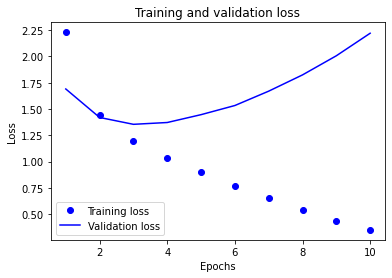

In [102]:
import matplotlib.pyplot as plt
acc = history.history['f1_m']
val_acc = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



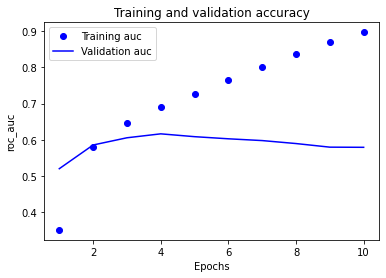

In [103]:
plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

## Enhancement

In [104]:
model_lstmBid = models.Sequential()
model_lstmBid.add(layers.Embedding(vocab_size + 1,128))
model_lstmBid.add(layers.Dropout(0.4))
model_lstmBid.add(layers.Bidirectional(layers.LSTM(64)))
model_lstmBid.add(layers.Dense(len(labels), activation='softmax'))


In [105]:
model_lstmBid.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc', f1_m])
model_lstmBid.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         9662720   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 41)                5289      
Total params: 9,766,825
Trainable params: 9,766,825
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model_lstmBid.fit(x_trainArr,y_train,epochs=10,validation_data=(x_valArr,y_val))

Epoch 1/10
5010/5010 [==============================] - 69s 13ms/step - loss: 1.8194 - acc: 0.5196 - f1_m: 0.4693 - val_loss: 1.4413 - val_acc: 0.6046 - val_f1_m: 0.5788
Epoch 2/10
5010/5010 [==============================] - 67s 13ms/step - loss: 1.3031 - acc: 0.6347 - f1_m: 0.6128 - val_loss: 1.3292 - val_acc: 0.6292 - val_f1_m: 0.6142
Epoch 3/10
5010/5010 [==============================] - 67s 13ms/step - loss: 1.1562 - acc: 0.6674 - f1_m: 0.6516 - val_loss: 1.3142 - val_acc: 0.6303 - val_f1_m: 0.6230
Epoch 4/10
5010/5010 [==============================] - 67s 13ms/step - loss: 1.0601 - acc: 0.6896 - f1_m: 0.6769 - val_loss: 1.3164 - val_acc: 0.6316 - val_f1_m: 0.6273
Epoch 5/10
5010/5010 [==============================] - 66s 13ms/step - loss: 0.9875 - acc: 0.7061 - f1_m: 0.6974 - val_loss: 1.3297 - val_acc: 0.6309 - val_f1_m: 0.6279
Epoch 6/10
5010/5010 [==============================] - 66s 13ms/step - loss: 0.9279 - acc: 0.7214 - f1_m: 0.7134 - val_loss: 1.3651 - val_acc: 0.6291

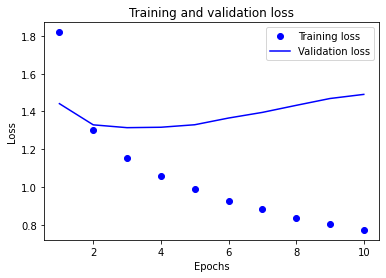

In [107]:
import matplotlib.pyplot as plt
acc = history.history['f1_m']
val_acc = history.history['val_f1_m']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

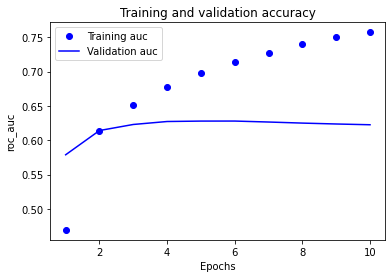

In [108]:
plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

## Final Results and Conclusion

- Bidirectional LSTM gives the highest acc & f_score with dropout 0.4

- take higher maximum len of words lead to more accurate model